In [ ]:
## lrasmy@Zhilab last revised August 1 2021 ##
##############################################

In [3]:
### Mount your google drive ###
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Required packages

Make sure that you are using a GPU Runtime


In [ ]:
### install required packages
! pip install lifelines --user
! pip install pip install 'ray[default]'
! pip install 'ray[tune]'

In [ ]:
import os
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import time
from tqdm import tqdm

import sklearn.metrics as m
from sklearn.metrics import roc_auc_score
from termcolor import colored


import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

###GPU enabling and device allocation
use_cuda = torch.cuda.is_available()
#if use_cuda: torch.cuda.set_device(7)




#### Please Note: if any error message displayed or you installed fresh packages, please make sure you run the following pytorch_ehr import cell **twice**

---



---



In [5]:
from importlib import reload

### import pytorch ehr files
try:
  import sys
  sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
  import pytorch_ehr
  import pytorch_ehr.models as model 
  from pytorch_ehr.EHRDataloader import EHRdataloader
  from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
  import pytorch_ehr.utils_final as ut 
  from pytorch_ehr.EHREmb import EHREmbeddings
except:
  exit()
  print('Notebook restarted after package installation')

### load preprocessed data

In [8]:
input_dir='/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Data_Prep/data/processed_data/'
data_prefix='Mimic_PT_mortality_dp_v1'
output_dir = '/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/Model_output/'
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

In [9]:
### Load the preprocessed data

train_sl= pickle.load(open(input_dir+data_prefix+'.combined.train', 'rb'),encoding='bytes')
test_sl= pickle.load(open(input_dir+data_prefix+'.combined.test', 'rb'), encoding='bytes')
valid_sl= pickle.load(open(input_dir+data_prefix+'.combined.valid', 'rb'), encoding='bytes')
# types dictionary
types_d=pickle.load(open(input_dir+data_prefix+'.types', 'rb'), encoding='bytes')
types_d_rev = dict(zip(types_d.values(),types_d.keys()))
input_size_l=[max(types_d_rev.keys())+1]
print (len(train_sl),len(valid_sl),len(test_sl))
print(input_size_l)

37049 5292 10585
[27362]


In [10]:
omop_pts=pickle.load(open('/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Data_Prep/data/processed_data.omop_pts', 'rb'), encoding='bytes')
test_sl2=[]
for p in test_sl:
  if p[0] in omop_pts : test_sl2.append(p)

pickle.dump(test_sl2, open(input_dir+data_prefix+'.combined.test2', 'wb'), -1)


In [11]:
def load_mbs_var_list(sets_list,packpadmode,task,bs=128,half=True):
    if task: multiLbl=True
    mb_lists=[]
    for dset in sets_list:
        print (' creating the list of minibatches')
        dataset = EHRDataset(dset,sort= True, model='RNN')
        data_mbs = list(tqdm(EHRdataloader(dataset, batch_size = bs, packPadMode = packpadmode,multilbl=multiLbl)))
        mb_lists.append(data_mbs)
    return mb_lists


In [12]:
[train_mbs,valid_mbs,test_mbs]=load_mbs_var_list([train_sl,valid_sl,test_sl],packpadmode=True,task='mort',bs=256)

  0%|          | 0/145 [00:00<?, ?it/s]

 creating the list of minibatches
multilabel data processing


  0%|          | 0/21 [00:00<?, ?it/s]

 creating the list of minibatches
multilabel data processing


  0%|          | 0/42 [00:00<?, ?it/s]

 creating the list of minibatches
multilabel data processing


100%|██████████| 42/42 [00:04<00:00, 10.07it/s]


### Model Training

#### Binary Classification

In [13]:
#### Binary classification Model
ehr_model=model.EHR_RNN(input_size_l,embed_dim=64, hidden_size=32, n_layers=1,cell_type='GRU',bii=False ,time=True, packPadMode=True, surv=False, cls_dim=1)
if use_cuda:ehr_model.cuda()
train_auc_allep,valid_auc_allep,test_auc_allep,RNN_f_label,RNN_f_score=ut.run_dl_model(ehr_model,train_mbs,valid_mbs,[test_mbs],output_dir+'ACM_BCB_t1.pth',output_dir+'ACM_BCB_t1.st',wmodel='RNN',packpadmode=True,task='mort',opt='Adamax')


weights :  None
Epoch:  0  Train_auc : 0.9552520821064044  , Valid_auc :  0.9381769971777331  Avg Loss:  0.24972253457225604  , Train Time : 0m 0s
 & Test_auc s :  [0.9401851890463849]
Eval Time : 0m 0s

 Confusion matrix yellow
[[8953  208]
 [ 727  697]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      9161
         1.0       0.77      0.49      0.60      1424

    accuracy                           0.91     10585
   macro avg       0.85      0.73      0.77     10585
weighted avg       0.90      0.91      0.90     10585

Epoch:  1  Train_auc : 0.9652026164300077  , Valid_auc :  0.9442523122677635  Avg Loss:  0.19291570474361552  , Train Time : 0m 0s
 & Test_auc s :  [0.9471766152068675]
Eval Time : 0m 0s

 Confusion matrix yellow
[[8626  535]
 [ 348 1076]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      9161
         1.0      

#### Survival

In [14]:
###Survival Model
ehr_model_s=model.EHR_RNN(input_size_l,embed_dim=64, hidden_size=32, n_layers=1,cell_type='GRU',bii=False ,time=True, packPadMode=True, surv=True)
if use_cuda:ehr_model_s.cuda()

train_auc_allep_S,valid_auc_allep_S,test_auc_allep_S,RNN_f_label_S,RNN_f_score_S=ut.run_dl_model_surv(ehr_model_s,train_mbs,valid_mbs,[test_mbs],output_dir+'ACM_BCB_s1.pth',output_dir+'ACM_BCB_s1.st',wmodel='RNN',packpadmode=True,task='mort_surv',patience=5)


Epoch:  0  Train_cindex : 0.9254682016968017  , Valid_cindex :  0.9018613156454984  Avg Loss:  3.7622567998951877  , Train Time : 0m 0s
 & Test_auc s :  [0.9097767195008065]
Eval Time : 0m 0s
Epoch:  1  Train_cindex : 0.9463623011816882  , Valid_cindex :  0.9114014247861294  Avg Loss:  3.2413876928132153  , Train Time : 0m 0s
 & Test_auc s :  [0.9171244941398048]
Eval Time : 0m 0s
Epoch:  2  Train_cindex : 0.9576866444874876  , Valid_cindex :  0.9115747162764445  Avg Loss:  2.961409904216898  , Train Time : 0m 0s
 & Test_auc s :  [0.9161447484688957]
Eval Time : 0m 0s
Epoch:  3  Train_cindex : 0.964489731050019  , Valid_cindex :  0.9077070152521267  Avg Loss:  2.7341148170931584  , Train Time : 0m 0s
Epoch:  4  Train_cindex : 0.9712149966232244  , Valid_cindex :  0.9082660866077861  Avg Loss:  2.529479238082623  , Train Time : 0m 0s
Epoch:  5  Train_cindex : 0.973901117208393  , Valid_cindex :  0.9068067247000613  Avg Loss:  2.3389043018735687  , Train Time : 0m 0s
Epoch:  6  Train_cin

### Hyperparameter Tunninig

5 years ago, Bayesian optimization was the SOTA of hyperparemeters search, an example resource is Botorch 

Nowadays there many new packages for hyperparameter search exist, some popular examples include RayTune and Optuna 

Actually you can even combine both where you can get the benefit of the best computational resources utilization from ray tune and the optuna search algorithm.
More examples are on:

 Pytorch Raytune Tutorial: https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html?highlight=transformer 

Using Optuna algorithm in Raytune:
https://docs.ray.io/en/master/tune/api_docs/suggestion.html#tune-optuna

Optuna code examples (select pytorch): https://optuna.org/#code_examples

Optuna tutorial on multi-objective optimization: https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html#sphx-glr-tutorial-20-recipes-002-multi-objective-py


####### here I'll only show a very shallow hand written example on the main concept for the sake of time


In [48]:
def run_dl_model_hps(config, input_size_1=[27362],epochs=100, task='mort', w_model='RNN', packpadmode=True, patience=10):
    ### for raytune, you need to limit your input to the config or use tune.with_parameters 
    ### for optuna, your input will be the trial
    ### Further examples can be found above

    sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
    import pytorch_ehr
    from pytorch_ehr import models as model 
    from pytorch_ehr import utils_final as ut

    l2 = config['l2']
    lr = config['lr']
    #lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)  #### this is just an example in case you use optuna
    eps = config['eps']    
    try:
      opt = config['opt']
    except: 
      opt='Adamax'
      print('optimizer reset to Adamax') 
    try:
      embed_dim = config['embed_dim']
      hidden_size = config['hidden_size']
    except:
      embed_dim = 2**config['embed_dim_exp']
      hidden_size = 2**config['hidden_size_exp']
      print("embed_dim: ", embed_dim , " hidden_size" , hidden_size )

    ehr_model = model.EHR_RNN(input_size_1, embed_dim=embed_dim, hidden_size=hidden_size, n_layers=1, cell_type='GRU', bii=False , time=True)
    if use_cuda: ehr_model = ehr_model.cuda()

    if opt== 'Adadelta':
        #lr=1
        optimizer = optim.Adadelta(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ## rho=0.9
    elif opt== 'Adagrad':
        optimizer = optim.Adagrad(ehr_model.parameters(), lr=lr, weight_decay=l2) ##lr_decay no eps
    elif opt== 'Adam':
        optimizer = optim.Adam(ehr_model.parameters(), lr=lr, weight_decay=l2,eps=eps ) ## Beta defaults (0.9, 0.999), amsgrad (false)
    elif opt== 'Adamax':
        optimizer = optim.Adamax(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ### Beta defaults (0.9, 0.999)
    elif opt== 'RMSprop':
        optimizer = optim.RMSprop(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps)                
    elif opt== 'ASGD':
        optimizer = optim.ASGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters
    elif opt== 'SGD':
        optimizer = optim.SGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters
    

    ##Training epochs
    bestValidAuc = 0.0
    bestValidEpoch = 0

    ### epochs loop
    for ep in range(epochs):
        start = time.time()
        current_loss, train_loss = ut.trainbatches_outcomes(train_mbs, model= ehr_model, task=task, optimizer = optimizer,loss_fn = nn.BCELoss())
        avg_loss = np.mean(train_loss)
        train_time = ut.timeSince(start)
        eval_start = time.time()
        #Train_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, train_mbs, task=task, which_model = w_model)
        valid_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, valid_mbs, task=task, which_model = w_model)
        #print ("Epoch: " ,str(ep) ," Train_auc :" , str(Train_auc) , " , Valid_auc : " ,str(valid_auc) ," Avg Loss: " ,str(avg_loss), ' , Train Time :' , str(train_time) )
        if valid_auc > bestValidAuc: 
            bestValidAuc = valid_auc
            bestValidEpoch = ep
            bavg_loss= avg_loss
        if ep - bestValidEpoch >patience: break
    #tune.report(accuracy=bestValidAuc)
    return bestValidAuc,bavg_loss,bestValidEpoch

In [50]:
def loguniform (lower, upper):
  logmin = np.log(lower) / np.log(10)
  logmax = np.log(upper) / np.log(10)
  items = 10**(np.random.uniform(logmin, logmax, size=1))
  return (items.round(7)[0])

results_ft=[]
for opt in ['Adamax','Adagrad']:
  for run in range(2):
    config = {"l2": loguniform(1e-5, 1e-2),
              "lr": loguniform(1e-3, 1e-1),
              "opt": opt,
              "eps": loguniform(1e-6, 1e-2),
              "embed_dim_exp": np.random.randint(5, 8),
              "hidden_size_exp": np.random.randint(5, 9)}
    config['best_valid_auc'], config['avg_loss'], config['best_epoch']=run_dl_model_hps(config)
    results_ft.append(config)

pd.DataFrame(results_ft)

embed_dim:  64  hidden_size 128
embed_dim:  128  hidden_size 64
embed_dim:  128  hidden_size 32
embed_dim:  64  hidden_size 32


,l2,lr,opt,eps,embed_dim_exp,hidden_size_exp,best_valid_auc,avg_loss,best_epoch
0,0.000011,0.001571,Adamax,0.000005,6,7,0.935702,0.088833,15
1,0.000047,0.022186,Adamax,0.001750,7,6,0.939908,0.001788,84
2,0.000022,0.012363,Adagrad,0.005624,7,5,0.929112,0.073046,23
3,0.000062,0.014622,Adagrad,0.000003,6,5,0.938831,0.090043,23


In [ ]:
#### example code if you need to run raytune
#from ray import tune
#
#config = {"l2": tune.loguniform(1e-5, 1e-2),
#          "lr": tune.loguniform(1e-3, 1e-1),
#          "opt": tune.grid_search(['Adamax','Adagrad']),
#          "eps": tune.loguniform(1e-6, 1e-2),
#          "embed_dim": tune.sample_from(lambda _: 2 ** np.random.randint(5, 8)),
#          "hidden_size": tune.sample_from(lambda _: 2 ** np.random.randint(5, 9))}
#
#result=tune.run(run_dl_model_hps,config=config)

In [ ]:
#### later when you get results you can use something like
best_trial = result.get_best_trial("accuracy", "max")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation AUC: {}".format(best_trial.last_result["accuracy"]))

### Model Evaluation


#### Binary Classification Models

In [ ]:
### to load a trained mode
best_model_bc = torch.load(output_dir+'ACM_BCB_t1.pth')
if use_cuda:best_model_bc.cuda()

### create a minibatch list for my new test set
[valid_mbs,test2_mbs]=load_mbs_var_list([valid_sl,test_sl2],packpadmode=True,task='mort',bs=256)

### to get the predictions
t2_labels, t2_scores = ut.get_preds( test2_mbs , best_model_bc )
t2_metrics_df, t2_metrics_list = ut.cl_metrics_bc('Test2',t2_labels, t2_scores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
t2_metrics_df

  0%|          | 0/21 [00:00<?, ?it/s]

 creating the list of minibatches
multilabel data processing


100%|██████████| 1/1 [00:00<00:00, 104.78it/s]


 creating the list of minibatches
multilabel data processing


,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,Test2,0.021363,0.916667,0.729167,0.021363,1.0,0.777778,0.818182,0.5,1.0,0.666667,0.777778


In [ ]:
vlabels, vscores = ut.get_preds( valid_mbs , best_model_bc )
vmetrics_df, vmetrics_list = ut.cl_metrics_bc('valid',vlabels, vscores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
vmetrics_df

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,valid,0.080712,0.955314,0.777034,0.024286,0.950521,0.818081,0.89229,0.583756,0.898438,0.707692,0.891247


In [ ]:
cohorts_preds=[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze()),('valid',vlabels, vscores),('Test2',t2_labels, t2_scores)]


In [ ]:
df_metrics = ut.cl_metrics_m(cohorts_preds,bth=0.15)
df_metrics

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,Test 1,0.15,0.952259,0.768062,0.018276,0.950306,0.807262,0.908928,0.628499,0.840708,0.719278,0.919921
1,valid,0.15,0.955314,0.777034,0.024286,0.950521,0.818081,0.908919,0.637236,0.864583,0.733702,0.916446
2,Test2,0.15,0.916667,0.729167,0.021363,1.000000,0.777778,0.863636,0.600000,0.750000,0.666667,0.888889


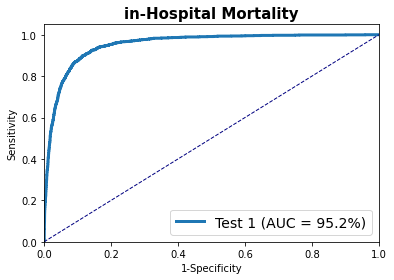

In [ ]:
ut.plot_roc_curve_combined_m("in-Hospital Mortality",[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())])

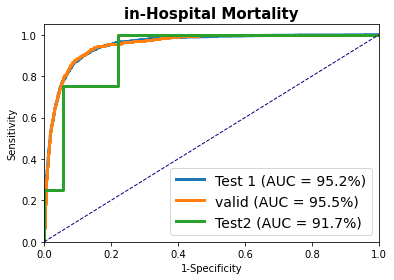

In [ ]:
ut.plot_roc_curve_combined_m("in-Hospital Mortality",cohorts_preds)

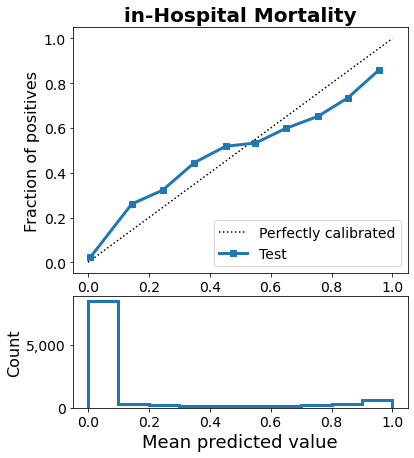

In [ ]:
ut.plot_calibration_curve_m("in-Hospital Mortality",1,[('Test', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())],n_bins=10)

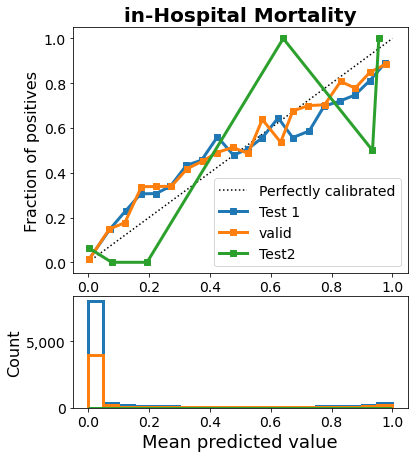

In [ ]:
ut.plot_calibration_curve_m("in-Hospital Mortality",1,cohorts_preds,n_bins=20)

### Survival Model


In [ ]:
### to load a trained model
best_model_surv = torch.load(output_dir+'ACM_BCB_s1.pth')
if use_cuda:best_model_surv.cuda()

### to get the predictions
t2_labels_s, t2_scores_s = ut.get_preds( test2_mbs , best_model_surv , surv=True )


In [ ]:
reload(ut)
df_ts2_pred=ut.convert_preds_df(t2_labels_s, t2_scores_s,surv=True)
df_ts2_pred

,Label,TTE,pred_nloghHF
0,0.0,11.0,1.821606
1,1.0,12.0,1.959840
2,0.0,7.0,0.139040
3,1.0,14.0,3.219073
4,0.0,19.0,-1.217319
5,1.0,0.0,3.422247
6,0.0,6.0,0.926608
7,0.0,5.0,-1.236388
8,0.0,5.0,-1.025039
9,0.0,3.0,4.107366


In [ ]:
vlabels_s, vscores_s = ut.get_preds( valid_mbs , best_model_surv , surv=True )
valid_ref= ut.create_ref_percentile(vlabels_s, vscores_s )
valid_ref

,percentile,pred_nloghHF
0,0.00,-3.09
1,0.01,-2.88
2,0.02,-2.73
3,0.03,-2.64
4,0.04,-2.55
...,...,...
96,0.96,4.50
97,0.97,4.89
98,0.98,5.37
99,0.99,5.94


In [ ]:
df_ts2_pred_perc=ut.assign_perc_based_on_reference(df_ts2_pred,valid_ref)
df_ts2_pred_perc

,Label,TTE,pred_nloghHF,percentile_from_ref,pred_max
0,0.0,11.0,1.821606,0.78,1.92
1,1.0,12.0,1.959840,0.79,2.02
2,0.0,7.0,0.139040,0.60,0.18
3,1.0,14.0,3.219073,0.90,3.34
4,0.0,19.0,-1.217319,0.36,-1.21
5,1.0,0.0,3.422247,0.91,3.51
6,0.0,6.0,0.926608,0.69,0.98
7,0.0,5.0,-1.236388,0.36,-1.21
8,0.0,5.0,-1.025039,0.41,-0.98
9,0.0,3.0,4.107366,0.95,4.21


In [ ]:
### We can do the following:
df_vs_pred = ut.get_preds_asdf( valid_mbs , best_model_surv , surv=True )
df_vs_pred['cohort']='valid'
df_ts_pred = ut.get_preds_asdf( test_mbs , best_model_surv , surv=True )
df_ts_pred['cohort']='test'
df_ts2_pred['cohort']='test2'
df_s_pred= pd.concat([df_ts_pred,df_vs_pred,df_ts2_pred])
df_s_pred_perc=ut.assign_perc_based_on_reference(df_s_pred,valid_ref)

#### and plot curves as shown later

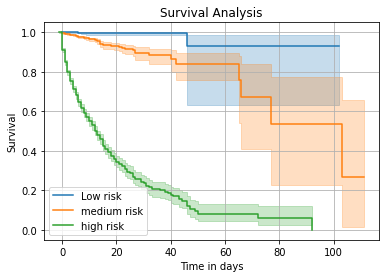

          removed  observed  censored  entrance  at_risk  survival prob
event_at                                                               
1.0           300       191       109         0     2776       0.847449
7.0           154        52       102         0     1110       0.615976
15.0           49        25        24         0      343       0.426979
17.0           25        10        15         0      258       0.393677
18.0           32        11        21         0      233       0.375092
19.0           26         9        17         0      201       0.358296
20.0           19         6        13         0      175       0.346012
22.0           11         4         7         0      135       0.324998
26.0            8         6         2         0       88       0.269602
28.0            4         1         3         0       70       0.255785
29.0            8         4         4         0       66       0.240282
30.0            2         1         1         0       58       0

In [ ]:
## Model initiation
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
subcohort=df_s_pred_perc[df_s_pred_perc['cohort']=='test']
for per_range in [['Low risk',0,0.3],['medium risk',0.3,0.7],['high risk',0.7,1]]:
    [subset,from_p,to_p]=per_range
    sub_per=subcohort[subcohort['percentile_from_ref'].between(from_p,to_p,inclusive='left')]
    t = sub_per['TTE']
    l = sub_per['Label']
    kmf.fit(t,l, label=subset)
    kmf.plot(title='Survival Analysis', ax=ax)#, at_risk_counts =True)
    plt.ylabel('Survival')
    plt.xlabel('Time in days')
    plt.grid(True)
plt.show()

table = kmf.event_table
table['survival prob'] = kmf.survival_function_
print(table.sample(n=20).sort_values(by='event_at'))

In [ ]:
#### calculate clinically relevant metrics
cohorts_preds_surv=[]
for cohort in df_s_pred_perc['cohort'].unique():
    subset_surv_pred=df_s_pred_perc[df_s_pred_perc['cohort']== cohort]
    for t in [1,2,3,5,7,14,21,30]:
        true_label=((subset_surv_pred['Label']==1)&(subset_surv_pred['TTE']<=t)).astype(float)
        cohorts_preds_surv.append([cohort+'_t'+str(t),true_label,subset_surv_pred['percentile_from_ref']])

df_metrics_surv = ut.cl_metrics_m(cohorts_preds_surv,bth=0.15)
df_metrics_surv[['dataset', 'day_window']]= df_metrics_surv['Cohort'].str.split('_t', expand=True)
df_metrics_surv['day_window']=df_metrics_surv['day_window'].astype(int)
df_metrics_surv

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity,dataset,day_window
0,test_t1,0.15,0.918683,0.397007,0.67,0.950593,0.704633,0.203401,0.056612,1.000000,0.107158,0.163409,test,1
1,test_t2,0.15,0.925855,0.484941,0.67,0.954545,0.715063,0.217950,0.073842,1.000000,0.137529,0.165945,test,2
2,test_t3,0.15,0.927307,0.527621,0.67,0.956688,0.723776,0.229759,0.087827,1.000000,0.161473,0.168061,test,3
3,test_t5,0.15,0.927982,0.583530,0.66,0.957011,0.724709,0.247898,0.109309,1.000000,0.197075,0.171420,test,5
4,test_t7,0.15,0.929788,0.615852,0.66,0.954833,0.733805,0.259802,0.123629,0.998193,0.220010,0.173560,test,7
5,test_t14,0.15,0.931278,0.659560,0.65,0.951368,0.736865,0.279547,0.147013,0.998480,0.256290,0.177473,test,14
6,test_t21,0.15,0.932842,0.673180,0.65,0.950714,0.743059,0.287482,0.156411,0.998571,0.270459,0.179096,test,21
7,test_t30,0.15,0.933045,0.677677,0.64,0.951950,0.733413,0.290883,0.160439,0.998607,0.276460,0.179801,test,30
8,valid_t1,0.15,0.913230,0.363378,0.64,0.957364,0.665872,0.193122,0.056979,1.000000,0.107814,0.151768,valid,1
9,valid_t2,0.15,0.927933,0.496003,0.68,0.952802,0.718554,0.208428,0.074867,1.000000,0.139306,0.154250,valid,2


dataset
test     AxesSubplot(0.125,0.125;0.775x0.755)
test2    AxesSubplot(0.125,0.125;0.775x0.755)
valid    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

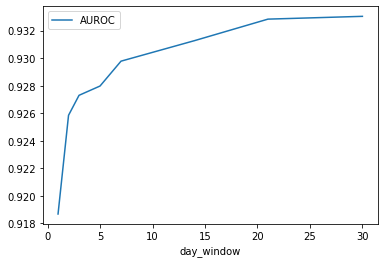

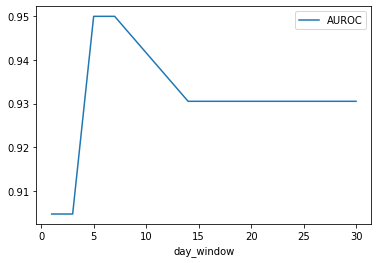

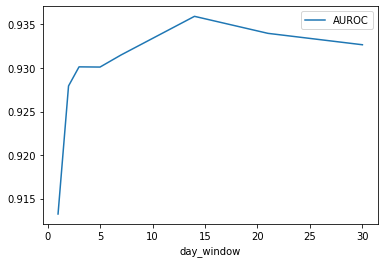

In [ ]:
df_metrics_surv.groupby('dataset')[['day_window','AUROC']].plot(x='day_window')